In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import os
from os import path

In [98]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: both


In [99]:
# Prompt user for type of analsyis
while (True):
    options = ["Bacillariophyceae", "Dinoflagellata", "Haptophyta",
               "other than diatoms, dinoflagellates, or haptophytes", "All", "All but other"]
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    analysis_type = int(input("Please enter a number (1-6) for the type analysis: "))
    if (analysis_type in range(1,7)):
        analysis_type = str(options[analysis_type-1])
        break
    print("Invalid argument")

1: Bacillariophyceae
2: Dinoflagellata
3: Haptophyta
4: other than diatoms, dinoflagellates, or haptophytes
5: All
6: All but other
Please enter a number (1-6) for the type analysis: 1


In [105]:
# Ask user if running analysis on a new cruise
while (True):
    reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Are you running the analysis on a new cruise? (y/n): n


In [106]:
# first call bash script to get necessary file inputs
# choose new_man_query_data.csv (60 samples) or man_query_data.csv (72 non-verified) 
# as input file during file 1b construction, then intermediate_names_ids.csv for R prompts
# only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
if ( not reply[0] != 'y'):
    # call bash script
    subprocess.call(['./exec.sh', reply[0]])
    import ifcb

In [107]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['permalink', 'data_provider_category_HumanObservation', 
               'higherClassification_group', 'scientificName_HumanObservation',
               'scientificNameID_HumanObservation', 'Biovolume']
elif (dataset_type == 'automated'):
    columns = ['permalink', 'data_provider_category_MachineObservation']
else:
    columns = ['permalink', 'data_provider_category_HumanObservation', 
               'data_provider_category_MachineObservation', 'higherClassification_group', 
               'scientificName_HumanObservation',
               'scientificNameID_HumanObservation', 'Biovolume']

In [108]:
# initialize data frame from input
samples = pd.read_csv("../auto_join/level_1b.csv", usecols=columns)

In [109]:
# get higher order data based on dataset
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, man_taxon_info, how='left', left_on='data_provider_category_HumanObservation', right_on='name')
    samples.rename(columns={'higherClassification_group':'higherClassification_group_manual'}, inplace=True)
else:
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated', 
                           'higherClassification_group':'higherClassification_group_manual'}, 
                   inplace=True)
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    samples = pd.concat([samples, man_taxon_info], axis=1, sort=False)

In [110]:
# separate out roi id from permalink
samples['roi'] = samples['permalink']
samples.roi = samples.roi.str.slice(68, 74)
# gets rid of leading zeros
samples.roi = samples.roi.str.lstrip("0")
# cut permalink to just be permalink of sample
samples.permalink = samples.permalink.str.slice(0, 67)

In [111]:
# read in volume data
volumes = pd.read_csv("volumes.csv")
# merge with samples
samples = pd.merge(samples, volumes, how='left', on='permalink')

In [112]:
# read in geolocation data
geo_data = pd.read_csv("geographic_subset.csv", usecols=['gps_furuno_latitude', 'gps_furuno_longitude', 
                                                         'date', 'pid'])
samples = pd.merge(samples, geo_data, how='left', left_on='permalink', right_on='pid')

In [113]:
# make level_2 summary file from manual data 
if (dataset_type != 'automated'):
    level_2 = samples
    level_2 = level_2.groupby(['permalink', 'data_provider_category_HumanObservation']).agg(
        {
            'scientificName_HumanObservation': 'first',
            'scientificNameID_HumanObservation': 'first',
            'higherClassification_group_manual': 'first',
            'roi': 'count',
            'Biovolume': 'sum',
            'volume_imaged': 'first',
            'date': 'first',
            'gps_furuno_latitude': 'first',
            'gps_furuno_longitude': 'first'
        }
    ).reset_index()
# rename roi to be abundance
level_2.rename(columns={'roi': 'Abundance'}, inplace=True)

In [114]:
# exclude abiotic particles from other
samples = samples[samples['alt_datasource'] != 'OCB']

In [115]:
# calculate abundance based on higher order and latitude
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = samples.groupby(['gps_furuno_latitude', 'higherClassification_group_automated']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first',
    }
).reset_index()
    # manual data frame
    manual_samples = samples.groupby(['gps_furuno_latitude', 'higherClassification_group_manual']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first'
    }
).reset_index()
else:
    samples = samples.groupby(['gps_furuno_latitude', 'higherClassification_group_{}'.format(dataset_type)]).agg(
        {
            'roi': 'count',
            'volume_imaged': 'first'
        }
    ).reset_index()

In [116]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_samples['concentration'] = auto_samples.roi/auto_samples.volume_imaged
    # convert to float
    auto_samples.concentration = auto_samples.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_samples['concentration'] = manual_samples.roi/manual_samples.volume_imaged
    # convert to float
    manual_samples.concentration = manual_samples.concentration.astype(float)
else:
    samples['concentration'] = samples.roi/samples.volume_imaged
    # convert to float
    samples.concentration = samples.concentration.astype(float)

In [117]:
# filter out to only read user specified analysis_type
if (dataset_type == 'both'):
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms,dinoflagellates,or haptophytes'
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] != analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] == analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] == analysis_type].reset_index()
else:
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms,dinoflagellates,or haptophytes'
        samples = samples[samples['higherClassification_group_{}'.format(dataset_type)] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        print('not here')
        samples = samples[samples['higherClassification_group_{}'.format(dataset_type)] == analysis_type].reset_index()

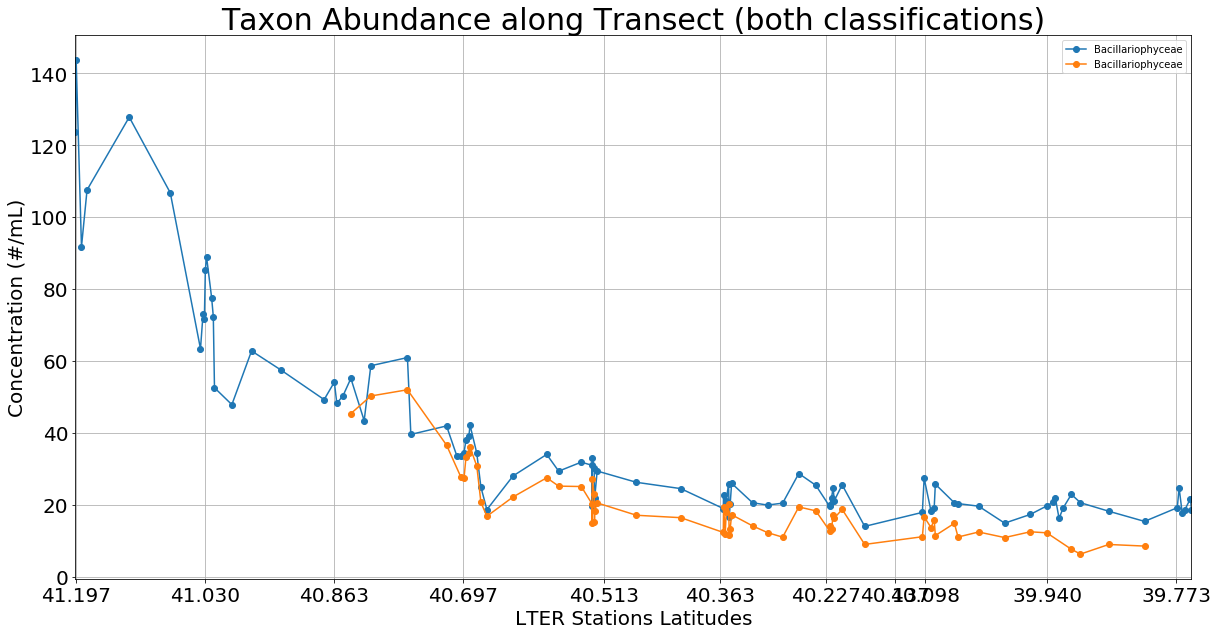

In [118]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(20,10))
# use unstack()
if (dataset_type == 'both'):
    grouped = auto_samples.groupby(['gps_furuno_latitude', 'higherClassification_group_automated']).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
    grouped = manual_samples.groupby(['gps_furuno_latitude', 'higherClassification_group_manual'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
    L=plt.legend(title=analysis_type)
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    grouped = samples.groupby(['gps_furuno_latitude', 'higherClassification_group_{}'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size = 20)
plt.ylabel('Concentration (#/mL)', size = 20)
plt.title('Taxon Abundance along Transect ({} classifications)'.format(dataset_type), size = 30)
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# invert x axis
ax.invert_xaxis()
ax.legend(title=None)
ax.tick_params(axis='both', which='major', labelsize=20)
fig = plt.gcf()
plt.show()

In [48]:
# Ask user if want to save graphs
while (True):
    reply = str(input('Save output? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        fig.savefig('taxon_abundance.png', bbox_inches='tight')
        level_2.to_csv('level_2.csv', index=None, header=True)
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Save output? (y/n): y
